Objective
This notebook compares different metrics for quantifying memorization in Fine-Tuned LLMs (GPT-2):
MIA Recall (Recollection-based): Traditional binary metric based on Likelihood Ratio thresholds (FPR 10%).
Counterfactual & Contextual Scores: Continuous metrics proposed by Ghosh et al. (2025) to distinguish between "rote memorization" and "contextual learning".
Hypothesis
We expect MIA Recall to saturate quickly (overestimation), while Contextual Score should provide a more nuanced view of the learning curve, especially for Low Entropy data.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- PLOTTING STYLE ---
sns.set_theme(style="whitegrid", context="talk") # 'talk' context makes fonts larger for presentations
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [8]:
# ==========================================
# CONFIGURATION: PATHS TO YOUR RESULTS
# ==========================================

# Replace this with the actual folder name of your completed run
# Example: "wikipedia/experiments/run_20251128_182313/results"
RESULTS_DIR = "wikipedia/experiments/run_20251128_182313/results" 

SUMMARY_FILE = os.path.join(RESULTS_DIR, "metrics_summary.csv")
DETAILS_FILE = os.path.join(RESULTS_DIR, "canary_details_full.csv")

# Verify files exist
if os.path.exists(SUMMARY_FILE) and os.path.exists(DETAILS_FILE):
    print(f"✅ Found Summary File: {SUMMARY_FILE}")
    print(f"✅ Found Details File: {DETAILS_FILE}")
else:
    print("❌ ERROR: Files not found. Please check the path in RESULTS_DIR.")

✅ Found Summary File: wikipedia/experiments/run_20251128_182313/results\metrics_summary.csv
✅ Found Details File: wikipedia/experiments/run_20251128_182313/results\canary_details_full.csv


In [9]:
# Load the datasets
df_summary = pd.read_csv(SUMMARY_FILE)
df_details = pd.read_csv(DETAILS_FILE)

# Display first rows to check structure
display(df_summary.head())
print("-" * 50)
print("Details Dataset Columns:", df_details.columns.tolist())

,epoch,mia_threshold_tau,mia_recall,avg_counterfactual_score,avg_contextual_score,n_train_samples
0,0,1.637327,0.833333,0.541661,0.540639,60
1,1,1.845011,0.900000,0.741515,0.734791,60
2,2,1.934137,0.983333,0.828207,0.820361,60
3,3,1.926235,1.000000,0.873814,0.866413,60
4,4,1.936455,1.000000,0.906604,0.899279,60


--------------------------------------------------
Details Dataset Columns: ['epoch', 'canary_id', 'global_loss_tgt', 'suffix_loss_tgt', 'split', 'suffix_loss_ref', 'global_loss_ref', 'loss_optimum', 'mia_score', 'counterfactual_score', 'contextual_score']


1. The Overestimation Problem
This plot compares the Binary MIA Recall (Red) against the continuous Contextual Score (Blue).
Observation: If the Red line jumps to 1.0 (100%) early while the Blue line is still rising, it proves that MIA flags samples as "memorized" too aggressively.
Thesis Argument: Recollection-based metrics overestimate memorization risk compared to Contextual metrics.

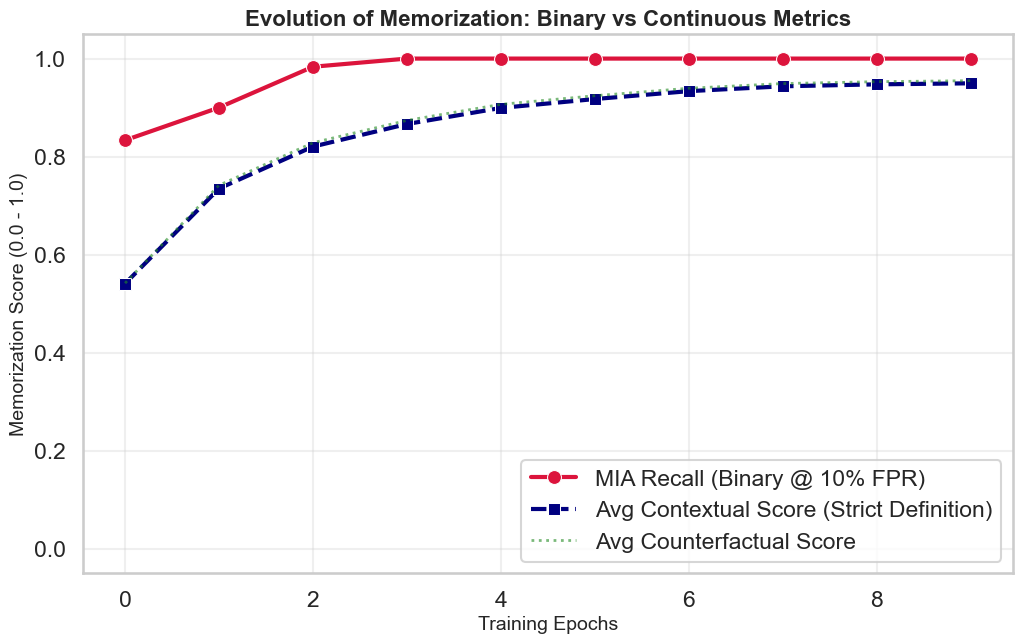

In [11]:
plt.figure(figsize=(12, 7))

# 1. MIA Recall (Binary)
sns.lineplot(
    data=df_summary, x="epoch", y="mia_recall", 
    label="MIA Recall (Binary @ 10% FPR)", 
    color="crimson", linewidth=3, marker="o", markersize=10
)

# 2. Contextual Score (Continuous)
sns.lineplot(
    data=df_summary, x="epoch", y="avg_contextual_score", 
    label="Avg Contextual Score (Strict Definition)", 
    color="navy", linewidth=3, linestyle="--", marker="s", markersize=8
)

# 3. Counterfactual Score (Continuous)
sns.lineplot(
    data=df_summary, x="epoch", y="avg_counterfactual_score", 
    label="Avg Counterfactual Score", 
    color="forestgreen", linewidth=2, linestyle=":", alpha=0.6
)

plt.title("Evolution of Memorization: Binary vs Continuous Metrics", fontweight='bold')
plt.xlabel("Training Epochs")
plt.ylabel("Memorization Score (0.0 - 1.0)")
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.show()

2. Dynamic Thresholding (Scientific Rigor)
Instead of using an arbitrary threshold (e.g., loss < 5.0), we calculated a dynamic threshold 
τ
τ
 at every epoch based on the Validation Set (Control Group).
This ensures a fixed False Positive Rate (FPR) of 10%.
Observation: The threshold likely decreases (becomes stricter) or fluctuates as the model adapts to the general domain.


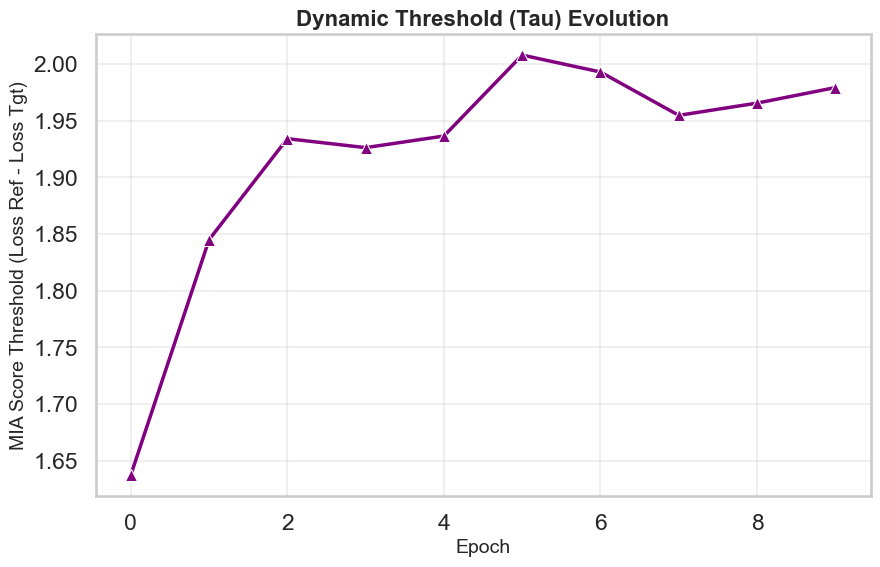

In [12]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_summary, x="epoch", y="mia_threshold_tau", 
    color="purple", marker="^", markersize=9, linewidth=2.5
)

plt.title("Dynamic Threshold (Tau) Evolution", fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("MIA Score Threshold (Loss Ref - Loss Tgt)")
plt.grid(True, alpha=0.3)

plt.show()

3. High vs. Low Entropy Canaries
Here we separate the behavior of High Entropy (Random Codes) vs Low Entropy (Plausible Sentences).
High Entropy (Random): We expect the Contextual Score to be very high (close to 1) because the Reference Model has zero chance of guessing them. Learning them is pure memorization.
Low Entropy (Natural): We expect the score to be nuanced. The Reference Model might already assign them a decent probability, so the gain from fine-tuning (Contextual Score) might be lower than for random strings.

In [14]:
# Filter only Training samples (the ones injected)
train_subset = df_details[df_details['split'] == 'train']

# Check if 'type' column exists (it should, from your generation script)
if 'type' in train_subset.columns:
    # Group data
    grouped_type = train_subset.groupby(['epoch', 'type'])['contextual_score'].mean().reset_index()

    plt.figure(figsize=(12, 7))
    
    sns.lineplot(
        data=grouped_type, x="epoch", y="contextual_score", hue="type", style="type",
        palette="viridis", linewidth=3, markers=True, markersize=10
    )

    plt.title("Contextual Memorization by Canary Type", fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Avg Contextual Score")
    plt.ylim(-0.05, 1.05)
    plt.legend(title="Canary Type")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Column 'type' not found in details CSV. Skipping this plot.")

Column 'type' not found in details CSV. Skipping this plot.


4. The Privacy Gap (Final Epoch)
This histogram shows the distribution of MIA Scores at the final epoch for Training Members vs Validation Non-Members.
Right Side (High Score): Training samples (Memorized).
Left Side (Low Score): Validation samples (Unknown).
Overlap Area: Where the attack fails (or False Positives occur).
Goal: We want to see a clear separation. If High Entropy samples are far right and Low Entropy are closer to the middle, it confirms that random strings are "more memorized" (or more easily distinguishable) than natural ones.

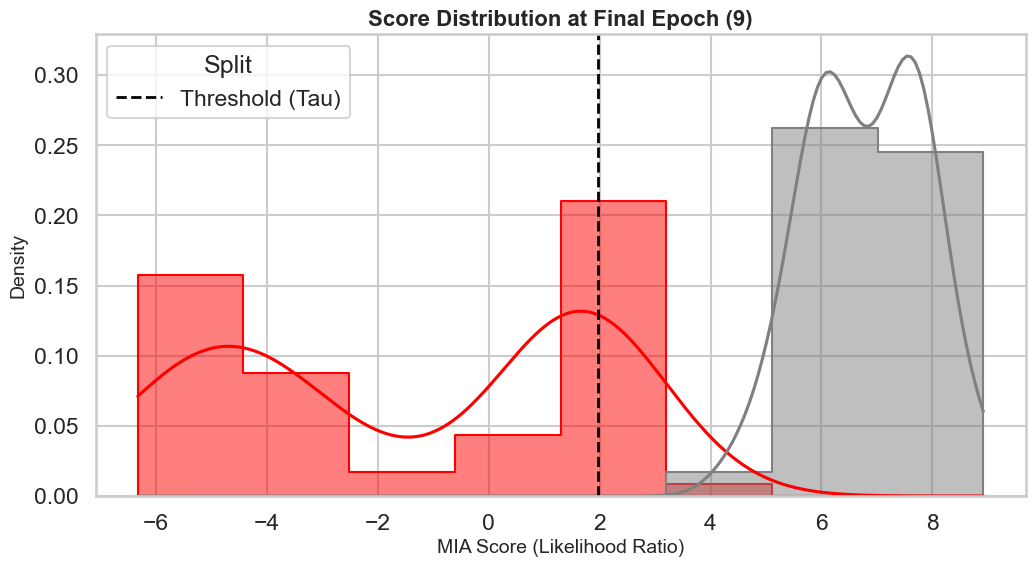

In [15]:
# Select the last epoch
last_epoch = df_details['epoch'].max()
final_df = df_details[df_details['epoch'] == last_epoch]

plt.figure(figsize=(12, 6))

sns.histplot(
    data=final_df, x="mia_score", hue="split", 
    kde=True, element="step", stat="density", common_norm=False, 
    palette=["grey", "red"], alpha=0.5
)

plt.axvline(
    x=df_summary[df_summary['epoch'] == last_epoch]['mia_threshold_tau'].values[0], 
    color='black', linestyle='--', linewidth=2, label='Threshold (Tau)'
)

plt.title(f"Score Distribution at Final Epoch ({last_epoch})", fontweight='bold')
plt.xlabel("MIA Score (Likelihood Ratio)")
plt.ylabel("Density")
plt.legend(title="Split")
plt.show()